##  Modeling the relationship between tectonic uplift, albedo, and heat transfer on regional surface temperature

This code uses an EBM diffusion model to simulate how tectonic uplift infulences albedo, and therefore regional surface temperatures through geologic time. Specifically, this project investigates the Himalayan Orogeny which began 50 million years ago when the global surface temperature was 9-14 degrees C warmer than modern day. The model consists of 368 cells, each of which are sampled elevation values taken along a 300km long cross section of Mount Everest (shown below).

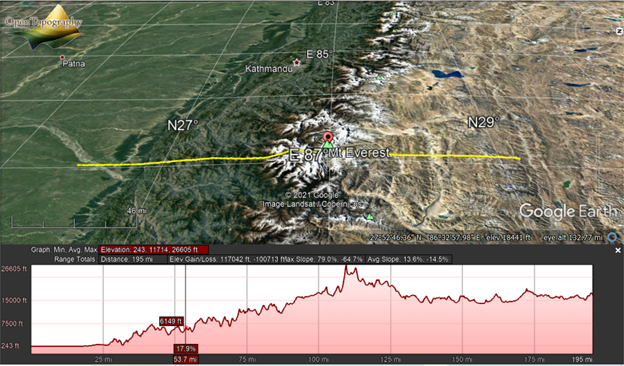

The model simulates the orogeny by initially setting each cell's elevation to 0m, and increasing linearly for the duration of the model run until reaching the current cross sectional altitudes. Each cell has an albedo parameter that changes with elevation using the equation:

$$ \alpha = 0.8-0.799 e^{(\frac{-E} {65.005})} $$

This alpha parameter is related to heat transfer from diffusion, longwave radiation, and short wave radiation in the non equilibrium equation below:

$$ \bar C\frac{\partial T}{\partial t} = \frac{S_0}{4} s(y)(1-\alpha)- (1-\frac{\epsilon}{2}) \sigma T^4 -\frac{\partial F}{\partial y}$$

such that as albedo changes with elevation, the surface temperature changes through time. 

The goal of this model is to simulate and evaluate how surface temperature changes in time with elevation and albedo. 


## Explanation of Heat Transfer Equation

#### Diffusion 
We can estimate the energy diffusion equation on the Earth's surface:

$$ \bar C\frac{\partial T}{\partial t} = \frac{\partial}{\partial y}\left(D(1-y^2)\frac{\partial T}{\partial y}\right)$$

This equation includes a latitude-dependant coefficient $d(y)=D(1-y^2)$. The term in the big parenthesis is latitude dependant energy flux $F(y) = -d(y) \frac{\partial T}{\partial y}$ so
$$ \bar C\frac{\partial T}{\partial t} = -\frac{\partial F(y)}{\partial y}$$
___

The energy at each point is changing due to absorbed shortwave radation (ASR) terms and outgoing longwave radiation (OLR).

$$ \bar C\frac{\partial T}{\partial t} = ASR(y)-OLR(y) -\frac{\partial F}{\partial y}$$

We can approximate ASR = $\frac{S_0}{4} s(y) (1-\alpha)$ where $s(y)=1.241 - 0.723 y^2$ and $\bar C$ is the heat capacity per unit area.

We can approximate OLR = $(1-\frac{\epsilon}{2}) \sigma T^4$. 

So the non-equilbrium equation to be solved is:

$$ \bar C\frac{\partial T}{\partial t} = \frac{S_0}{4} s(y)(1-\alpha)- (1-\frac{\epsilon}{2}) \sigma T^4 -\frac{\partial F}{\partial y}$$

#### Discretizing the equation
As before we will discretize the temperature and flux using a staggered grid. 
```  
      T0  T1  T2
    |-*-|-*-|-*-|
    F0  F1  F2  F3
```
Compute the flux at interfaces using centered finite difference on T:
$$ F_k = - D(1-y_k^2) \left(\frac{T_{i} -T_{i-1}}{\Delta y} \right)$$ 
where $y_k = k \Delta y -1 $.

Compute diffusion term at segment centers using centered finite differences on F:
$$ \textrm{diffusion}_i \approx -\frac{F_{i+1}-F_i}{\Delta y}$$

#### Boundary conditions
Closed boundary conditions are chosen since the model is only evaluating the region defined by the cross section.
Thus, 
$$F(t,y= 1)=0$$ 
$$F(t,y=-1)=0$$

In [156]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from   scipy.integrate import solve_ivp
import pandas as pd
import xlrd

#read excel file containing Topographic X-Section elevation values
        #### Change the path (in red) below to match the location of the downloaded excel file on your computer
df = pd.read_excel (r'C:\Users\Maddie Schwarz\Documents\ATOC 4850\Data_Final_Project\him_XElev_Excel.xls')

#extract column with elevation from excel file into pandas dataframe
Elev_column = pd.DataFrame(df, columns= ['Elevation'])

#flatten dataframe into 1D np array
Elev_array = Elev_column.values.flatten()

In [157]:
# One Dimensional Nonequilbrium Energy Balance Model with Diffusion 
%matplotlib inline

# Physical constants 
Re     = 6.371E6        # Radius of Earth in m
eps    = 0.82           # Emissivity fraction
sigma  = 5.67E-8        # Stephan Boltzmann constant in W / m^2 / K^4
c_s    = 712            # heat capacity of Silicon rock in J /kg / K
rho_s  = 2650           # density of Silicon rock in kg/m^3
c_w    = 4000           # heat capacity of water in J /kg / K
rho_w  = 1000           # density of water in kg/m^3
years  = 365.25*24*3600 # seconds in a year
S0     = 1361           # solar insolation in W m-2
dg2rad = np.pi/180.0    # converstion factor for degree to radians
days   = 24*3600        # seconds per day
e = 2.718282            # approx. mathematical value of e
eps   = 0.82            # Emissivity 
depth = 100             # depth of crust layer (meters)

# Set the diffusion coefficient
D1     = 0.1              # diffusion coefficient

# set time integration parameters
t_end = 50.0E6               # integration end time (50 million years = length of Himalayan Orogeny)
dt    = 1.0E6               # time integration maxium step size

times = np.arange(0,t_end,dt)  # array of timesteps for output

# create grid and set initial conditions
N     = 368 #number of elevation samples   #set number of segments
y_F   = np.linspace(-1,1,N+1)       # set position of interfaces
y_T   = (y_F[0:N]+y_F[1:N+1])/2     # set position of midpoints
dy    = y_F[1]-y_F[0]               # get segment length

# set initial conditions 
T0 = 300 + 0*y_T                     # constant initial temperature                   

### Heat capacity of earth, 100% silicate land of 100 m depth
vol = 4 *np.pi* Re**2 * depth   # Volume of top x-meters of earth (given by depth)
C_e = (c_w * vol * rho_w)       # heat capacity of earth in J K-1
Cbar  =  (C_e/(4*np.pi*Re**2))  # heat capacity per unit area in J m-2 K-1 


In [158]:
# Elevation and Albedo Functions

E0 = np.zeros(368) # array of cells' inital elevation (= 0 meters)

#Calculate Elevation thru time for each cell
def Elevation(t_end): 
    E_t = [] #empty Elevation array
    # find uplift rate for each cell in topographic x-section:
    for i in range(len(Elev_array)):
        m = (Elev_array[i]- E0[i])/(t_end-0)
        b = E0[i]
        E = m*times+b
        E_t.append(E) # add calculated elevations to empty list
    return E_t

# Calculate the elevation dependent albedo parameter for each cell
def albedo(t_end):
    E = Elevation(t_end) #call elevation function; array of elevations thru time
    alpha_t = []         # empty albedo list
    for j in range(len(Elev_array)):
        alpha = 0.8-0.799*e**((-1*E[j])/65.0057) # equation relating albedo to Elevation using data from Himalayas
        alpha_t.append(alpha)         # add calculated albedos to empty list
        alpha_tnp = np.array(alpha_t) # convert list into numpy array
    return alpha_tnp

E = np.array(Elevation(t_end)) # run elevation function and convert output to np array
a=albedo(t_end) # run albedo function

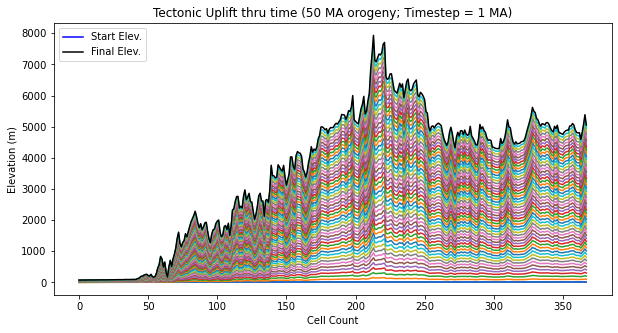

In [159]:
# plot of Himalayan tectonic uplift (50 million years)

fig = plt.figure(figsize=(10,5))

plt.plot(start_elev, 'b',label='Start Elev.') # initial elevation of every cell = 0m
plt.plot(E,)#label='Intermed. Elev.'); # intermediate elevation values
plt.plot(Elev_array,'k',label='Final Elev.'); # end elevation (modern x-section values)

plt.xlabel('Cell Count')
plt.ylabel('Elevation (m)')
plt.legend(loc="upper left")
plt.title('Tectonic Uplift thru time (50 MA orogeny; Timestep = 1 MA)');

#print(E.shape) #array shape is 368 dimensions, 50 elements

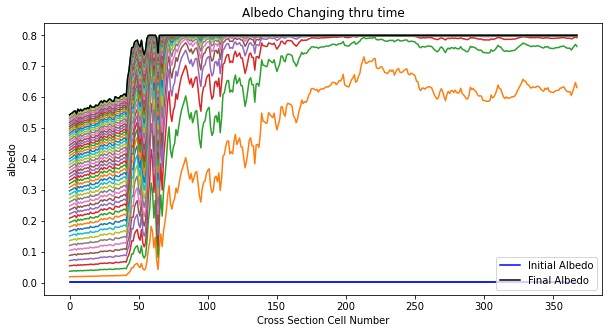

In [160]:
# Plot of Albedo thru time (50 million years)
fig = plt.figure(figsize=(10,5))
plt.plot(a)
plt.plot(a[0:368, 0],'blue', label='Initial Albedo')
plt.plot(a[0:368, -1],'black', label='Final Albedo') # last albeo value for each cell (column)
plt.xlabel('Cross Section Cell Number')
plt.ylabel('albedo')
plt.legend(loc="lower right")
plt.title('Albedo Changing thru time');

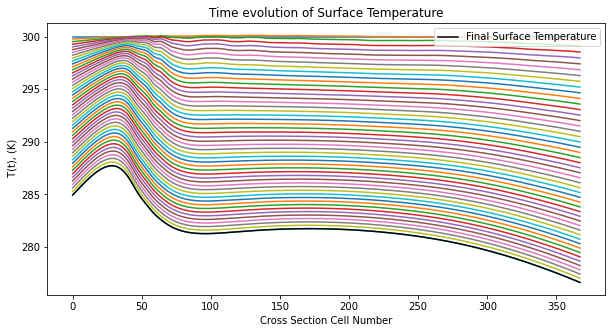

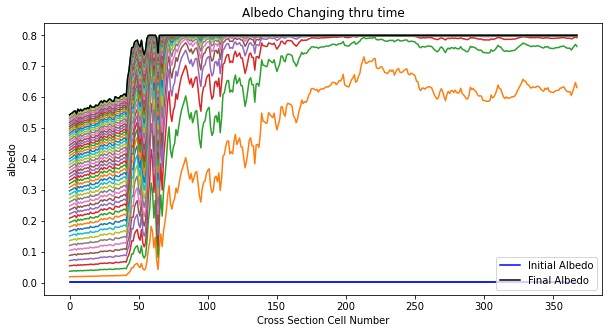

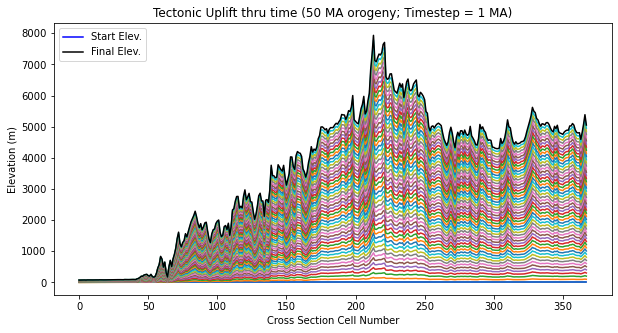

In [161]:
# Code for 1D EBM Diffusion model: 
def RHS(t,T):
    
    # find uplift rate for each cell in topographic x-section:
    El = np.zeros(N) #empty Elevation array
    for i in range(len(Elev_array)):
        m = (Elev_array[i] - E0[i])/(t_end-0)
        b = E0[i]
        El[i] = m*t+b
    #print(El)
    # calculate elevation-dependent albedo for each cell
    alpha = 0.8-0.799*e**((-1*El)/65.0057)
    
    # compute energy flux F at interfaces of cells
    F     = np.zeros(N+1)
    
    F[1:N]= -D1*(1-y_F[1:N]**2)*(T[1:N]-T[0:N-1])/dy #changed to match eqn for Fk above

    F[0]  = 0               # apply no flux b.c. at y=-1
    F[N]  = 0               # apply no flux b.c. at y=+1
    
    # compute diffusion term at the segment centers
    diffusion = -(F[1:N+1]-F[0:N])/dy
    
    # compute variables in right hand side of heat transfer equation
    rhs_np = np.zeros(shape = (N,))
    s_y = 1.241-(0.723*(y_T**2.0))
    ASR = (S0/4.0)*s_y*(1.0-alpha)
    OLR = (1.0-eps/2.0)*sigma*(T**4.0) 
    
    # compute right-hand-side of the equation
    rhs = (ASR-OLR+diffusion)/Cbar
    rhs_np = rhs
    return rhs_np

## call time integrator to solve the equation numerically 
    #Uses BDF method for time step:
solution = solve_ivp(RHS, (0,t_end), T0, "BDF", times, max_step=dt )

# extract time and temperature fields from the solution
t = solution.t # time values from solve_ivp stored as numpy.ndarray#T = solution.y 
T = solution.y # temperature values from solve_ivp stored as numpy.ndarray

# Plot of surface temperature change thru time
fig = plt.figure(figsize=(10,5))

plt.plot(T);
plt.plot(T[:,-1],'k', label='Final Surface Temperature')
plt.xlabel('Cross Section Cell Number')
plt.ylabel(' T(t), (K)')
plt.legend(loc="upper right")
plt.title('Time evolution of Surface Temperature');

# Plot of albedo change thru time
fig = plt.figure(figsize=(10,5))
plt.plot(a)
plt.plot(a[0:368, 0],'blue', label='Initial Albedo')
plt.plot(a[0:368, -1],'black', label='Final Albedo') # last albeo value for each cell (column)
plt.xlabel('Cross Section Cell Number')
plt.ylabel('albedo')
plt.legend(loc="lower right")
plt.title('Albedo Changing thru time');

# Plot of elevation change thru time
fig = plt.figure(figsize=(10,5))
plt.plot(start_elev, 'b',label='Start Elev.') # initial elevation of every cell = 0m
plt.plot(E,)#label='Intermed. Elev.'); # intermediate elevation values
plt.plot(Elev_array,'k',label='Final Elev.'); # end elevation (modern x-section values)
plt.xlabel('Cross Section Cell Number')
plt.ylabel('Elevation (m)')
plt.legend(loc="upper left")
plt.title('Tectonic Uplift thru time (50 MA orogeny; Timestep = 1 MA)');


In [162]:
print('Final Surface Temperature values in Kelvin', T[:,-1])

Final Surface Temperature values in Kelvin [284.94814183 285.08161278 285.21889954 285.35669526 285.49804187
 285.64151273 285.77567999 285.9131207  286.04698494 286.18020995
 286.30857567 286.43340178 286.55585178 286.67409847 286.7888749
 286.89805891 287.00506807 287.10646269 287.20134179 287.28873911
 287.36994717 287.44294502 287.50793041 287.5660734  287.61749972
 287.65933357 287.69248849 287.7149423  287.72515647 287.72348381
 287.70982616 287.6822668  287.6385389  287.57788714 287.50278611
 287.41170796 287.30336619 287.17697095 287.03336899 286.87159606
 286.69218889 286.49489388 286.27782052 286.0522775  285.82256305
 285.59586995 285.3778315  285.16748178 284.96726913 284.77714728
 284.59669196 284.4225397  284.25263125 284.09027009 283.92937211
 283.76676773 283.60512955 283.45061604 283.30444219 283.16636921
 283.03608659 282.91326067 282.7974822  282.6885011  282.58481045
 282.47802672 282.3772789  282.28243849 282.19324696 282.10956454
 282.03119532 281.95794393 281.889